# Neural Network Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
from keras import backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, model_from_json
from keras.metrics import CategoricalAccuracy, CategoricalCrossentropy
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, classification_report, SCORERS, log_loss

from numpy.random import seed
from tensorflow.random import set_seed

In [2]:
activities = {
    1: 'Walking',
    2: 'Walking Upstairs',
    3: 'Walking Downstairs',
    4: 'Sitting',
    5: 'Standing',
    6: 'Laying'
}

## Data Pipeline

In [3]:
# load a single file as a numpy array
def load_file(filepath):
    df = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return df.values

# load a list of files into a 3D array of [observations, timesteps, features(x,y,z)]
def load_group(files, prefix=''):
    loaded = list()
    for f in files:
        data = load_file(prefix + f)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    files = list()
    # body acceleration
    files += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    files += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # total acceleration
    files += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # load input data
    X = load_group(files, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    # load all train
    X_train, y_train = load_dataset_group('train', prefix)
    # load all test
    X_test, y_test = load_dataset_group('test', prefix)
    # zero-offset class values
    y_train = y_train - 1
    y_test = y_test - 1
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    print(f"""Dataset loaded.
Training Set:
X_train {X_train.shape} y_train {y_train.shape}
Test Set:
X_test {X_test.shape} y_test {y_test.shape}""")
    return X_train, y_train, X_test, y_test

## Hyperparameters Tuning

In [4]:
def create_model(model):
    classifier = KerasClassifier(model, verbose=2)
    return classifier

In [5]:
# GridSearch
def grid(classifier):
    # define the grid search parameters
    batch_size = [8]#, 16, 32, 64]
    epochs = [10, 15]#, 20, 25]
    validation_split=[0.2]
    param_grid = dict(batch_size=batch_size, epochs=epochs, validation_split=validation_split)
    grid = GridSearchCV(estimator=classifier, param_grid=param_grid, n_jobs=-1, cv=5, return_train_score=True, verbose=2)
    grid_result = grid.fit(X_train, y_train)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid_result

## Evaluate Model

In [6]:
def evaluate_model(X_train, y_train, X_test, y_test, params, model):
    epochs, batch_size = params["epochs"], params["batch_size"]
    es =EarlyStopping(monitor='val_loss', patience=5)
    classifier=model()
    history = classifier.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, validation_split=0.2, callbacks=[es])
    # evaluate model
    _, accuracy = classifier.evaluate( X_test, y_test, batch_size=batch_size, verbose=0)
    return history, accuracy, classifier

In [7]:
def run_model(model, grid_result):
    history, score, classifier = evaluate_model(X_train, y_train, X_test, y_test, grid_result.best_params_, model)
    score = score * 100.0
    print('> %.3f' % (score))
    results=pd.DataFrame(history.history, index=history.epoch)
    return results, classifier

In [8]:
def plot_loss(results):
    plt.style.use('seaborn-whitegrid')
    sns.set(style="white", font_scale = 1.5)
    fig, axes = plt.subplots(1,2, figsize=(20,5), sharex=True)
    axes[0].set_title('Loss')
    axes[0].plot(results['loss'], label='train', )
    axes[0].plot(results['val_loss'], label='test')
    axes[0].legend()
    #plot accuracy during training
    axes[1].set_title('Accuracy')
    axes[1].plot(results['accuracy'], label='train')
    axes[1].plot(results['val_accuracy'], label='test')
    axes[1].legend()
    plt.show()
    return

In [9]:
def run(model):
    classifier=create_model(model)
    grid_result=grid(classifier)
    results, classifier=run_model(model, grid_result)
    plot_loss(results)
    return classifier

### Base Model

In [10]:
X_train, y_train, X_test, y_test = load_dataset(prefix="data/")
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

Dataset loaded.
Training Set:
X_train (7352, 128, 9) y_train (7352, 6)
Test Set:
X_test (2947, 128, 9) y_test (2947, 6)


#### LSTM Network Model

In [11]:
def model1():
    seed(17)
    set_seed(17)
    K.clear_session()
    model = Sequential()
    model.add(LSTM(64, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    return model

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 17.8min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 24.7min finished


Epoch 1/15
736/736 - 25s - loss: 0.9856 - accuracy: 0.5880 - val_loss: 1.2567 - val_accuracy: 0.4398
Epoch 2/15
736/736 - 25s - loss: 0.8912 - accuracy: 0.6161 - val_loss: 0.9935 - val_accuracy: 0.6744
Epoch 3/15
736/736 - 25s - loss: 0.7306 - accuracy: 0.6849 - val_loss: 0.8623 - val_accuracy: 0.7451
Epoch 4/15
736/736 - 25s - loss: 0.6286 - accuracy: 0.7473 - val_loss: 0.7998 - val_accuracy: 0.7702
Epoch 5/15
736/736 - 25s - loss: 0.4708 - accuracy: 0.7992 - val_loss: 0.7653 - val_accuracy: 0.7995
Epoch 6/15
736/736 - 25s - loss: 0.3547 - accuracy: 0.8604 - val_loss: 0.7680 - val_accuracy: 0.8470
Epoch 7/15
736/736 - 25s - loss: 0.3311 - accuracy: 0.8694 - val_loss: 0.4860 - val_accuracy: 0.8668
Epoch 8/15
736/736 - 25s - loss: 0.2105 - accuracy: 0.9186 - val_loss: 0.4762 - val_accuracy: 0.8804
Epoch 9/15
736/736 - 25s - loss: 0.1970 - accuracy: 0.9277 - val_loss: 0.4452 - val_accuracy: 0.8885
Epoch 10/15
736/736 - 25s - loss: 0.1556 - accuracy: 0.9417 - val_loss: 0.4774 - val_accura

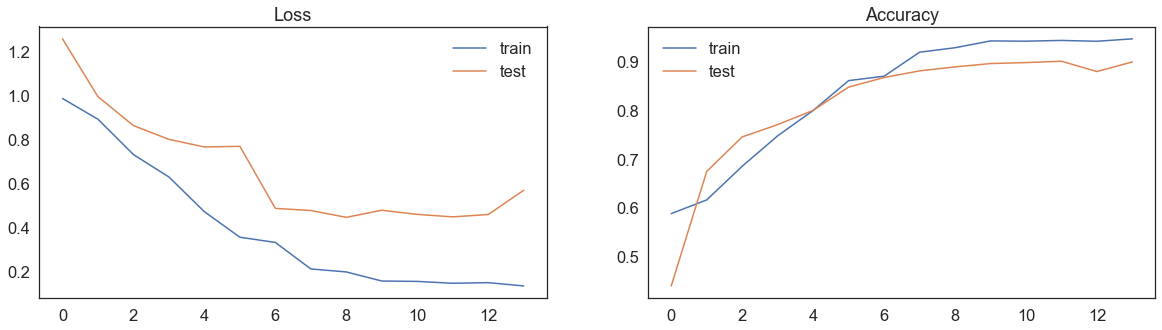

In [12]:
classifier1=run(model1)

#### CNN

In [13]:
def model2():
    seed(17)
    set_seed(17)
    K.clear_session()
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu',input_shape=(n_timesteps, n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  5.3min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.0min finished


Epoch 1/10
736/736 - 5s - loss: 0.3229 - accuracy: 0.8680 - val_loss: 0.3495 - val_accuracy: 0.8865
Epoch 2/10
736/736 - 5s - loss: 0.1261 - accuracy: 0.9481 - val_loss: 0.2981 - val_accuracy: 0.8946
Epoch 3/10
736/736 - 5s - loss: 0.1155 - accuracy: 0.9534 - val_loss: 0.3498 - val_accuracy: 0.8729
Epoch 4/10
736/736 - 5s - loss: 0.1074 - accuracy: 0.9549 - val_loss: 0.4071 - val_accuracy: 0.9048
Epoch 5/10
736/736 - 5s - loss: 0.0958 - accuracy: 0.9585 - val_loss: 0.4005 - val_accuracy: 0.8831
Epoch 6/10
736/736 - 5s - loss: 0.0773 - accuracy: 0.9634 - val_loss: 0.4077 - val_accuracy: 0.9096
Epoch 7/10
736/736 - 5s - loss: 0.1132 - accuracy: 0.9582 - val_loss: 0.4573 - val_accuracy: 0.8994
Epoch 8/10
736/736 - 5s - loss: 0.0843 - accuracy: 0.9612 - val_loss: 0.4170 - val_accuracy: 0.8939
Epoch 9/10
736/736 - 5s - loss: 0.0791 - accuracy: 0.9633 - val_loss: 0.3957 - val_accuracy: 0.9137
Epoch 10/10
736/736 - 5s - loss: 0.0736 - accuracy: 0.9672 - val_loss: 0.4135 - val_accuracy: 0.9048

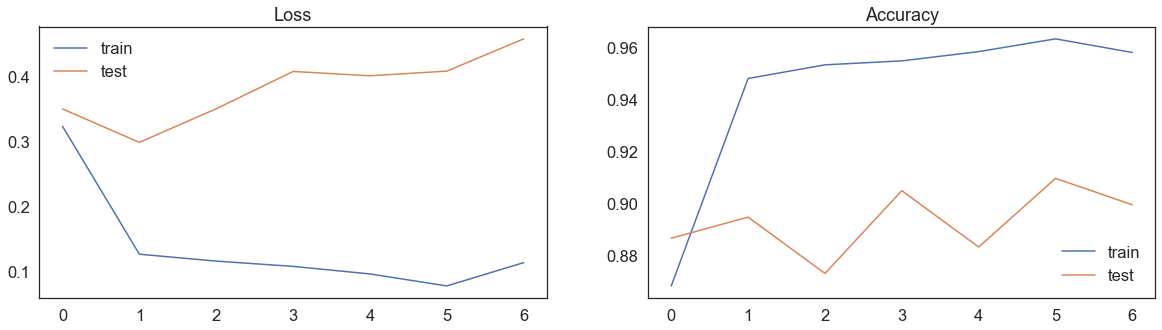

In [14]:
classifier2=run(model2)

### CNN-LSTM Network Model

In [15]:
# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 32
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

In [16]:
def model3():
    seed(17)
    set_seed(17)
    K.clear_session()
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  7.1min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  9.8min finished


Epoch 1/10
736/736 - 8s - loss: 0.5442 - accuracy: 0.7674 - val_loss: 0.4512 - val_accuracy: 0.8939
Epoch 2/10
736/736 - 7s - loss: 0.2024 - accuracy: 0.9228 - val_loss: 0.4356 - val_accuracy: 0.8919
Epoch 3/10
736/736 - 7s - loss: 0.1548 - accuracy: 0.9410 - val_loss: 0.3741 - val_accuracy: 0.9089
Epoch 4/10
736/736 - 7s - loss: 0.1234 - accuracy: 0.9454 - val_loss: 0.5026 - val_accuracy: 0.9062
Epoch 5/10
736/736 - 7s - loss: 0.1138 - accuracy: 0.9476 - val_loss: 0.4473 - val_accuracy: 0.9041
Epoch 6/10
736/736 - 7s - loss: 0.1046 - accuracy: 0.9502 - val_loss: 0.3305 - val_accuracy: 0.9123
Epoch 7/10
736/736 - 7s - loss: 0.1028 - accuracy: 0.9565 - val_loss: 0.4294 - val_accuracy: 0.9001
Epoch 8/10
736/736 - 7s - loss: 0.1013 - accuracy: 0.9548 - val_loss: 0.3274 - val_accuracy: 0.9232
Epoch 9/10
736/736 - 7s - loss: 0.0943 - accuracy: 0.9572 - val_loss: 0.5141 - val_accuracy: 0.9055
Epoch 10/10
736/736 - 7s - loss: 0.0918 - accuracy: 0.9570 - val_loss: 0.3173 - val_accuracy: 0.9062

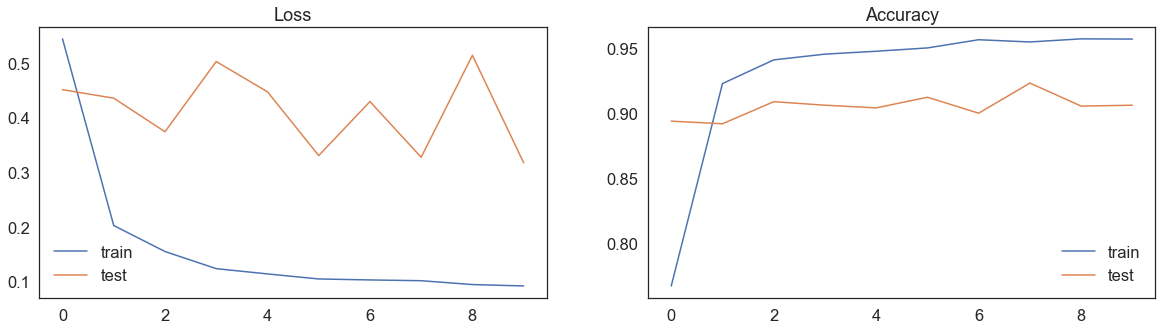

In [17]:
classifier3=run(model3)

## Performance of Final Model

In [33]:
def perform(model):
    display(model.summary())
    # Final evaluation of the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: %f" % (scores[0]))
    print("Test Accuracy: %f%%" % (scores[1]*100))
    return

In [28]:
def confusion(model):
    y_pred=model.predict(X_test)
    
    # Confusion Matrix
    y_predict=pd.Series([activities[i+1] for i in np.argmax(y_pred, axis=1)])
    y_actual=pd.Series([activities[i+1] for i in np.argmax(y_test, axis=1)])


    # Code for drawing seaborn heatmaps
    class_names = list(activities.values())
    df_heatmap = pd.DataFrame(confusion_matrix(y_actual, y_predict) )

    plt.style.use('seaborn-whitegrid')
    sns.set(style="white", font_scale = 1.5)

    fig = plt.figure(figsize=(15,12))
    heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d", cmap="Blues")

    # Setting tick labels for heatmap
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    heatmap.set_xticklabels(class_names)
    heatmap.set_yticklabels(class_names)
    plt.ylabel('Actual Activity')
    plt.xlabel('Predicted Activity')
    plt.title("Confusion Matrix\n")
    #plt.savefig("graph/Confusion Matrix.png")
    plt.show()
    return y_predict, y_actual

In [29]:
def class_report(model):
    cr=classification_report(y_actual, y_predict, target_names=activities.values(), digits=4)
    print(cr)

In [30]:
def plot_ROC(model):
    n_classes = 6

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.style.use('seaborn-whitegrid')
    sns.set(style="white", font_scale = 1.2)
    plt.figure(figsize=(12,12))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = ['aqua', 'darkorange', 'cornflowerblue', "red", "green", "black"]
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='{0} (area = {1:0.2f})'
                 ''.format(activities[i+1], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for each activity')
    plt.legend(loc="lower right")
    #plt.savefig("graph/ROC.png")
    plt.show()
    return

In [31]:
def final_performance(model):
    perform(model)
    y_predict, y_actual = confusion(model)
    class_report(model)
    plot_ROC(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 15, 64)      0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 15, 64)      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 13, 128)     24704     
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 6, 128)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 6, 128)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 768)         0

None

Test Loss: 0.420725
Test Accuracy: 91.788262%


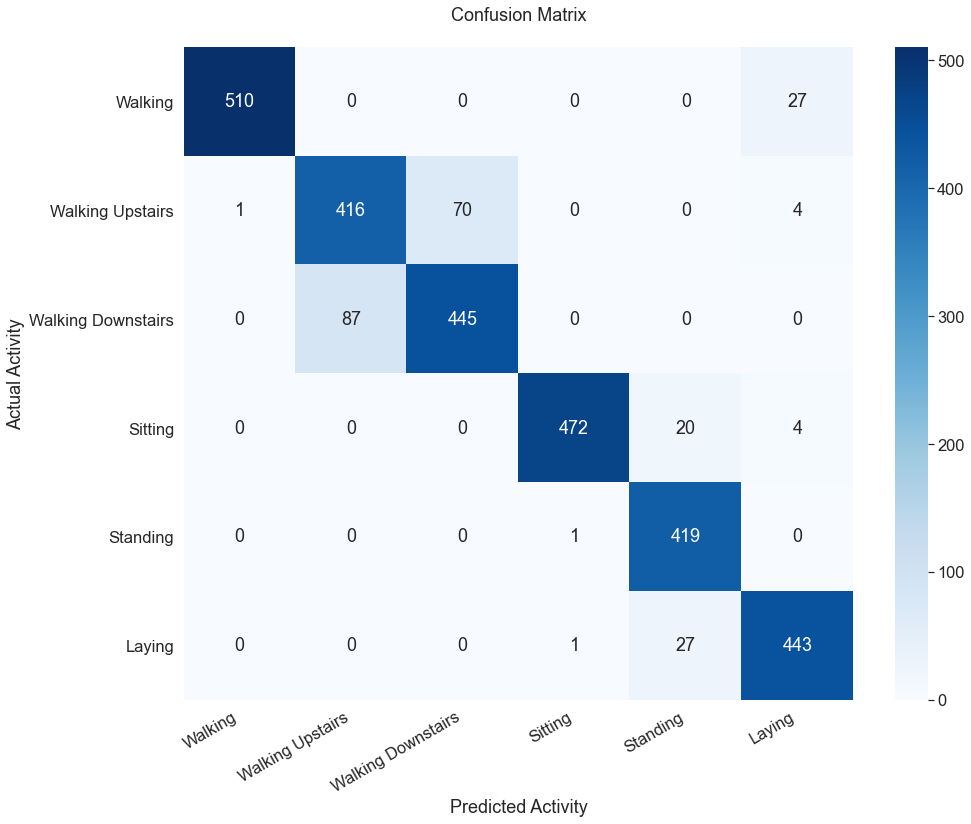

                    precision    recall  f1-score   support

           Walking     0.9980    0.9497    0.9733       537
  Walking Upstairs     0.8270    0.8473    0.8370       491
Walking Downstairs     0.8641    0.8365    0.8500       532
           Sitting     0.9958    0.9516    0.9732       496
          Standing     0.8991    0.9976    0.9458       420
            Laying     0.9268    0.9406    0.9336       471

          accuracy                         0.9179      2947
         macro avg     0.9185    0.9205    0.9188      2947
      weighted avg     0.9195    0.9179    0.9181      2947



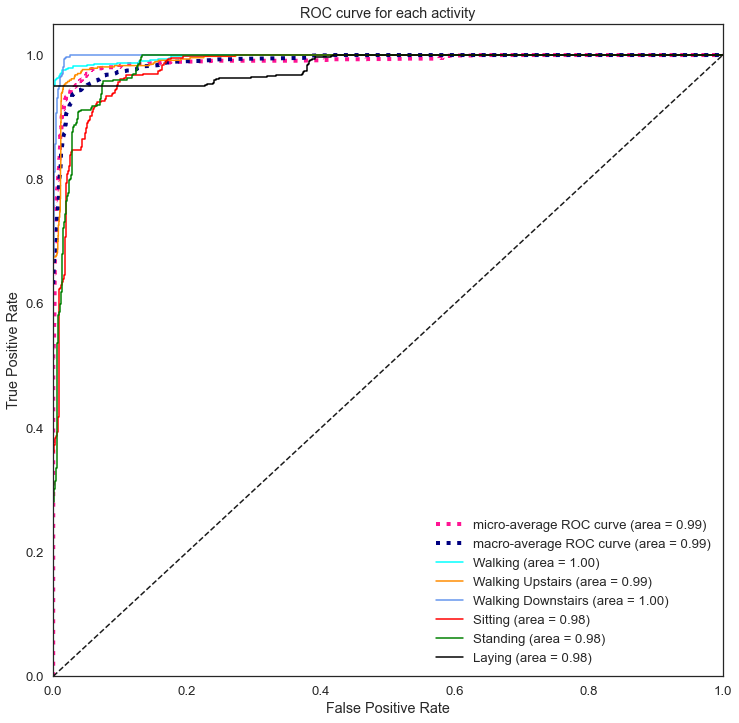

In [34]:
final_performance(classifier3)

## ORIGINAL
The first run of the model which was used for the presentation

In [49]:
X_train, y_train, X_test, y_test = load_dataset(prefix="data/")
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 32
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

Dataset loaded.
Training Set:
X_train (7352, 128, 9) y_train (7352, 6)
Test Set:
X_test (2947, 128, 9) y_test (2947, 6)


In [247]:
# early stopping to choose best epoch
es =EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint(filepath='models/model.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', mode='min', save_best_only=True)


In [250]:
verbose, epochs, batch_size = 1, 24, 64
# define model
K.clear_session()
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2, callbacks=[es, mc])
# evaluate model
accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)

Epoch 1/24
92/92 [==============================] - 3s 28ms/step - loss: 0.9410 - accuracy: 0.5853 - val_loss: 0.6208 - val_accuracy: 0.7736
Epoch 2/24
92/92 [==============================] - 3s 28ms/step - loss: 0.4275 - accuracy: 0.8230 - val_loss: 0.4337 - val_accuracy: 0.8518
Epoch 3/24
92/92 [==============================] - 3s 29ms/step - loss: 0.2666 - accuracy: 0.9012 - val_loss: 0.3368 - val_accuracy: 0.9014
Epoch 4/24
92/92 [==============================] - 3s 30ms/step - loss: 0.1948 - accuracy: 0.9269 - val_loss: 0.3308 - val_accuracy: 0.8987
Epoch 5/24
92/92 [==============================] - 3s 30ms/step - loss: 0.1534 - accuracy: 0.9418 - val_loss: 0.3048 - val_accuracy: 0.8906
Epoch 6/24
92/92 [==============================] - 3s 30ms/step - loss: 0.1303 - accuracy: 0.9466 - val_loss: 0.2949 - val_accuracy: 0.9177
Epoch 7/24
92/92 [==============================] - 3s 29ms/step - loss: 0.1241 - accuracy: 0.9498 - val_loss: 0.3208 - val_accuracy: 0.8960
Epoch 8/24
92

In [157]:
verbose, epochs, batch_size = 1, 24, 64
# early stopping to choose best epoch
es =EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint(filepath='models/model.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', mode='min', save_best_only=True)
# define model
K.clear_session()
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(Dropout(0.1))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2,callbacks=[es, mc])
# evaluate model
accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)

Epoch 1/24
92/92 [==============================] - 3s 27ms/step - loss: 0.6469 - accuracy: 0.7286 - val_loss: 0.5747 - val_accuracy: 0.8015
Epoch 2/24
92/92 [==============================] - 4s 40ms/step - loss: 0.2498 - accuracy: 0.9038 - val_loss: 0.3163 - val_accuracy: 0.9021
Epoch 3/24
92/92 [==============================] - 4s 42ms/step - loss: 0.1416 - accuracy: 0.9425 - val_loss: 0.2705 - val_accuracy: 0.9205
Epoch 4/24
92/92 [==============================] - 3s 38ms/step - loss: 0.1122 - accuracy: 0.9546 - val_loss: 0.3120 - val_accuracy: 0.8892
Epoch 5/24
92/92 [==============================] - 4s 41ms/step - loss: 0.0973 - accuracy: 0.9578 - val_loss: 0.2913 - val_accuracy: 0.9225
Epoch 6/24
92/92 [==============================] - 4s 40ms/step - loss: 0.0854 - accuracy: 0.9602 - val_loss: 0.3070 - val_accuracy: 0.9211
Epoch 7/24
92/92 [==============================] - 4s 39ms/step - loss: 0.0928 - accuracy: 0.9595 - val_loss: 0.3239 - val_accuracy: 0.9211
Epoch 8/24
47

In [273]:
fit_history="""0.6469 0.7286 0.5747 0.8015,
0.2498 0.9038 0.3163 0.9021,
0.1416 0.9425 0.2705 0.9205,
0.1122 0.9546 0.3120 0.8892,
0.0973 0.9578 0.2913 0.9225,
0.0854 0.9602 0.3070 0.9211,
0.0928 0.9595 0.3239 0.9211,
0.0961 0.9543 0.3261 0.9313"""

In [284]:
history=pd.DataFrame([i.split(" ") for i in fit_history.split(",\n")], columns=["Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"])

for i in history.columns:
    history[i]=pd.to_numeric(history[i])

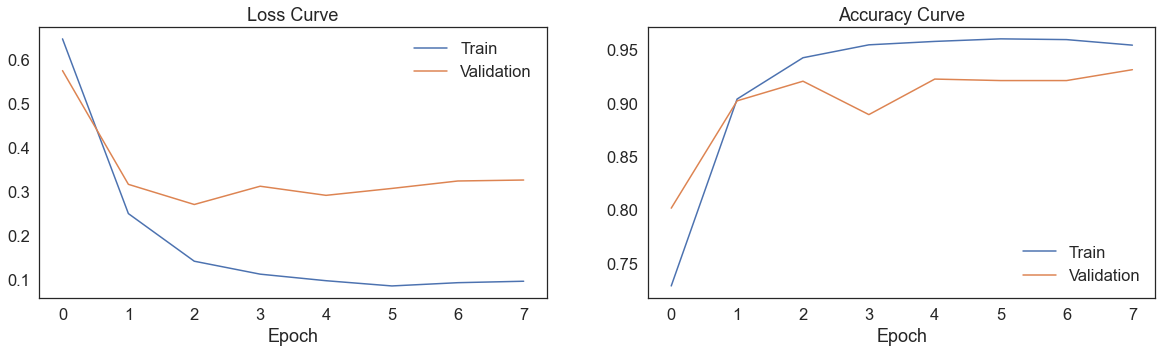

In [391]:
plt.style.use('seaborn-whitegrid')
sns.set(style="white", font_scale = 1.5)
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].set_title('Loss Curve')
axes[0].plot(history["Train Loss"], label='Train', )
axes[0].plot(history["Validation Loss"], label='Validation')
axes[0].set_xlabel("Epoch")
axes[0].legend()
#plot accuracy during training
axes[1].set_title('Accuracy Curve')
axes[1].plot(history["Train Accuracy"], label='Train')
axes[1].plot(history['Validation Accuracy'], label='Validation')
axes[1].legend()
axes[1].set_xlabel("Epoch")
plt.savefig("graph/Training Process Loss vs Accuracy2.png")
plt.show()

In [ ]:
{"train loss": [0.6469, 0.2498, 0.1416,0.1122,0.0973,0.0854,0.0928,0.0961]}

In [134]:
# load a saved model
from keras.models import load_model
saved_model = load_model('model.01-0.64.h5')

In [174]:
"""#saving model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")"""

Saved model to disk


In [43]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")


Loaded model from disk


In [54]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 15, 64)      0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 13, 128)     24704     
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 6, 128)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 4, 256)      98560     
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 2, 256)      0         
_________________________________________________________________
dropout (Dropout)            (None, None, 2, 256)      0

#### Performance Table

In [12]:
# Final evaluation of the model
scores = loaded_model.evaluate(X_test, y_test, verbose=0)
print("Test Loss: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

Test Loss: 0.348009
Test Accuracy: 92.568713%


In [15]:
y_pred=loaded_model.predict(X_test)

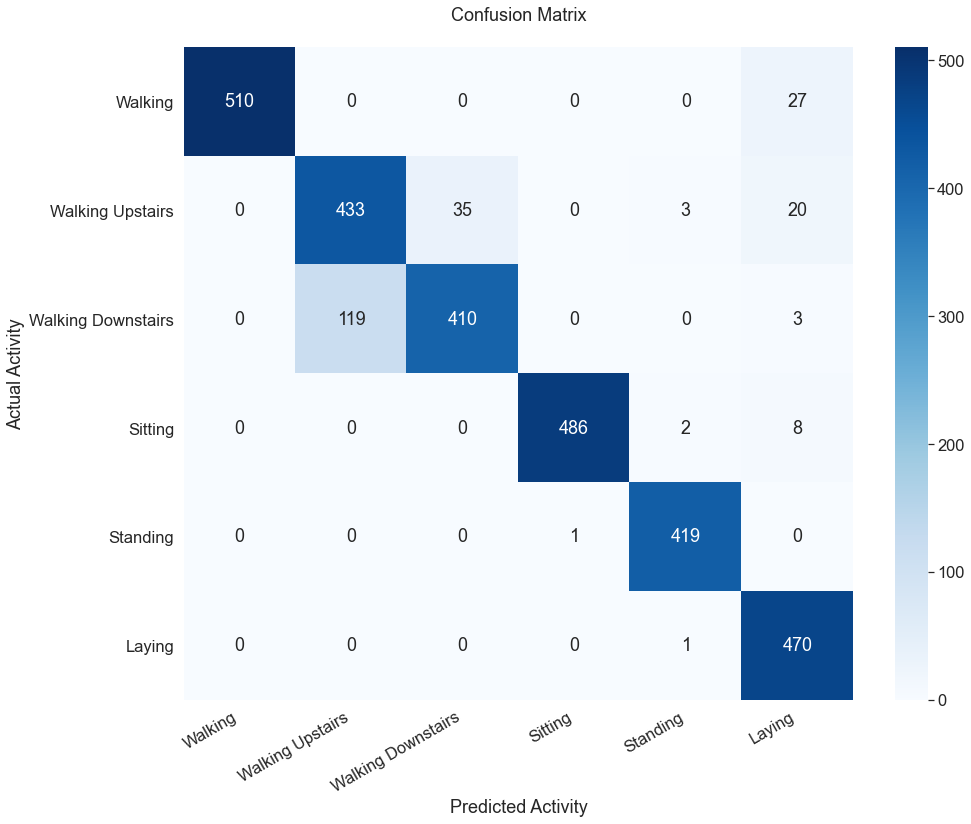

In [16]:
# Confusion Matrix
y_predict=pd.Series([activities[i+1] for i in np.argmax(y_pred, axis=1)])
y_actual=pd.Series([activities[i+1] for i in np.argmax(y_test, axis=1)])


# Code for drawing seaborn heatmaps
class_names = list(activities.values())
df_heatmap = pd.DataFrame(confusion_matrix(y_actual, y_predict) )

plt.style.use('seaborn-whitegrid')
sns.set(style="white", font_scale = 1.5)

fig = plt.figure(figsize=(15,12))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d", cmap="Blues")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right')
heatmap.set_xticklabels(class_names)
heatmap.set_yticklabels(class_names)
plt.ylabel('Actual Activity')
plt.xlabel('Predicted Activity')
plt.title("Confusion Matrix\n")
#plt.savefig("graph/Confusion Matrix.png")
plt.show()

In [17]:
cr=classification_report(y_actual, y_predict, target_names=activities.values(), digits=4)
print(cr)

                    precision    recall  f1-score   support

           Walking     1.0000    0.9497    0.9742       537
  Walking Upstairs     0.7844    0.8819    0.8303       491
Walking Downstairs     0.9213    0.7707    0.8393       532
           Sitting     0.9979    0.9798    0.9888       496
          Standing     0.9859    0.9976    0.9917       420
            Laying     0.8902    0.9979    0.9409       471

          accuracy                         0.9257      2947
         macro avg     0.9300    0.9296    0.9275      2947
      weighted avg     0.9300    0.9257    0.9255      2947



In [357]:
perf=pd.DataFrame([["{0:0.2f}%".format(100*precision_score(y_actual, y_predict, average="micro")), 
                    "{0:0.2f}%".format(100*recall_score(y_actual, y_predict, average="micro")),
                    "{0:0.2f}%".format(100*f1_score(y_actual, y_predict, average="micro"))],
                  ["{0:0.2f}%".format(100*precision_score(y_actual, y_predict, average="macro")), 
                    "{0:0.2f}%".format(100*recall_score(y_actual, y_predict, average="macro")),
                    "{0:0.2f}%".format(100*f1_score(y_actual, y_predict, average="macro"))]], 
                  index=["Micro Average", "Macro Average"], columns=["Precision", "Recall", "F Score"])

In [358]:
perf

,Precision,Recall,F Score
Micro Average,92.57%,92.57%,92.57%
Macro Average,93.00%,92.96%,92.75%


In [356]:
print("Accuracy: {0:0.2f}%".format(100*accuracy_score(y_actual, y_predict)))

Accuracy: 92.57%


In [355]:
print("Precision: {0:0.2f}%".format(100*precision_score(y_actual, y_predict, average="micro")))
print("Recall: {0:0.2f}%".format(100*recall_score(y_actual, y_predict, average="micro")))
print("f1_score: {0:0.2f}%".format(100*f1_score(y_actual, y_predict, average="micro")))

Precision: 92.57%
Recall: 92.57%
f1_score: 92.57%


In [349]:
print("Precision: {0:0.2f}%".format(100*precision_score(y_actual, y_predict, average="macro")))
print("Recall: {0:0.2f}%".format(100*recall_score(y_actual, y_predict, average="macro")))
print("f1_score: {0:0.2f}%".format(100*f1_score(y_actual, y_predict, average="macro")))


Precision: 93.00%
Recall: 92.96%
f1_score: 92.75%


#### ROC Curve

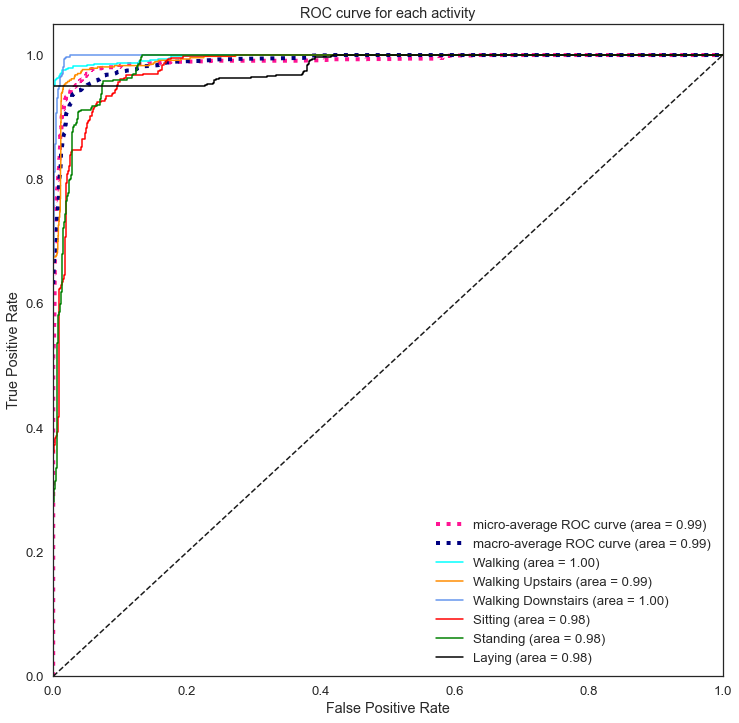

In [38]:
n_classes = 6

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
#Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.style.use('seaborn-whitegrid')
sns.set(style="white", font_scale = 1.2)
plt.figure(figsize=(12,12))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', "red", "green", "black"]
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='{0} (area = {1:0.2f})'
             ''.format(activities[i+1], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for each activity')
plt.legend(loc="lower right")
plt.savefig("graph/ROC.png")
plt.show()